In [17]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy

from pathlib import Path
from tqdm import tqdm
from numpy import array
from core.utils import *
import atlas_mpl_style as ampl
import random
import mplhep as hep
hep.style.use("ATLAS")
import random

pkl_path = '/global/cfs/projectdirs/atlas/wys/HEP_Repo/QG_Calibration/NewWorkflow/note_plots'
pkl_path = Path(pkl_path)
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'Extraction_Results'


In [15]:
reweighting_vars = ['jet_nTracks', 'GBDT_newScore']
nominal_keys = [reweighting_var + '_quark_reweighting_weights' for reweighting_var in reweighting_vars]
WPs = [0.5, 0.6, 0.7, 0.8]
partons=['Quark','Gluon']
label_ptrange = [500, 600, 800, 1000, 1200, 1500]
bin_centers = 0.5 * (np.array(label_ptrange[:-1]) + np.array(label_ptrange[1:]))
Map_var_title = {
    "jet_pt": "$p_{T}$",
    "jet_nTracks": "$n_{trk}$",
    "jet_trackBDT": "old BDT",
    "jet_eta": "$\eta$",
    "jet_trackC1": "$C_{1}$",
    "jet_trackWidth": "$w^{trk}$",
    "GBDT_newScore": "BDT"
}
HistBins={
   "jet_nTracks": np.linspace(0, 60, 61),
   'GBDT_newScore' : np.linspace(-5.0, 5.0, 101),
}

Map_gen={
"nominal": "Pythia 8",
"hadronization/sherpa": "Sherpa (Cluster Had.)",
"hadronization/sherpalund": "Sherpa (String Had.)",
"matrix_element/powhegpythia":"Powheg + Pythia 8",
"parton_shower/herwigangle":"Herwig (Angluar Shower)",
"parton_shower/herwigdipole":"Herwig (Dipole Shower)",
}

In [25]:
def safe_array_divide_unumpy(numerator, denominator):
    if 0 in unumpy.nominal_values(denominator):
        _denominator_nominal_values = unumpy.nominal_values(denominator)
        _denominator_std_devs = unumpy.std_devs(denominator)
        zero_idx = np.where(_denominator_nominal_values==0)[0]
        _denominator_nominal_values[zero_idx] = np.inf
        _denominator_std_devs[zero_idx] = 0 
        _denominator = unumpy.uarray(_denominator_nominal_values, _denominator_std_devs)

        ratio = np.true_divide(numerator, _denominator) 
        # raise Warning(f"0 exists in the denominator for unumpy, check it!")
    else:
        ratio = np.true_divide(numerator, denominator)        
    return ratio

markers=['s','^','*','X','P','1']
ind = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
ind_all = ind(15)

/tmp/ipykernel_63348/1110478497.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})


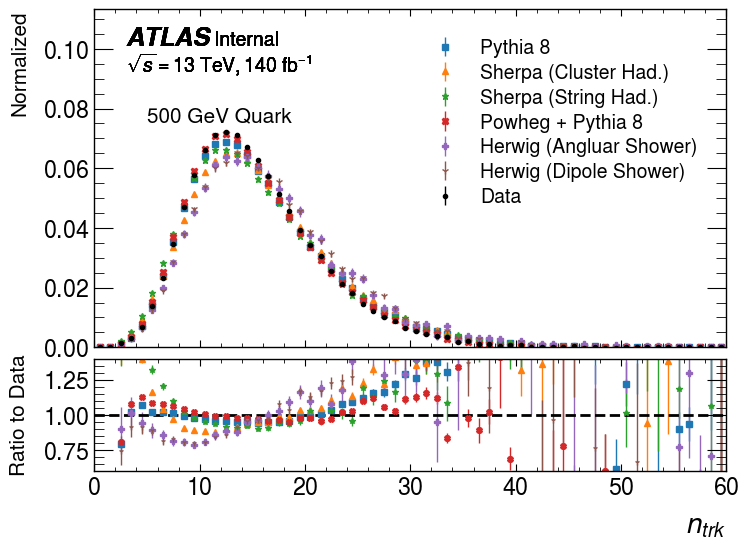

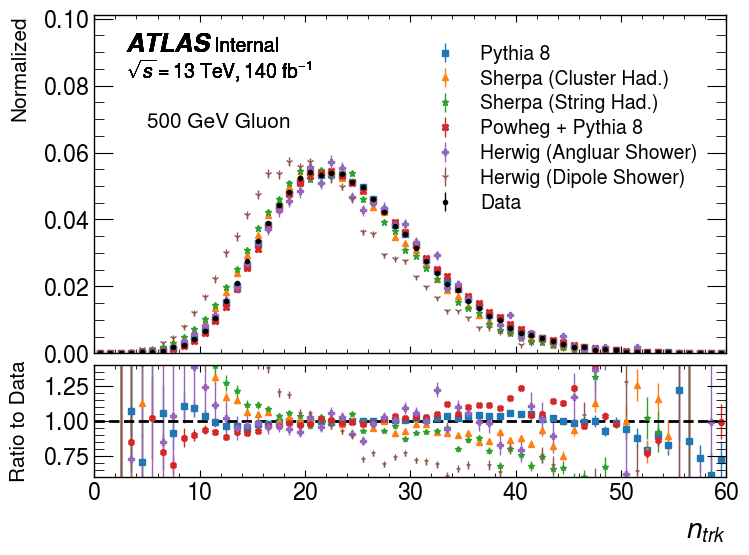

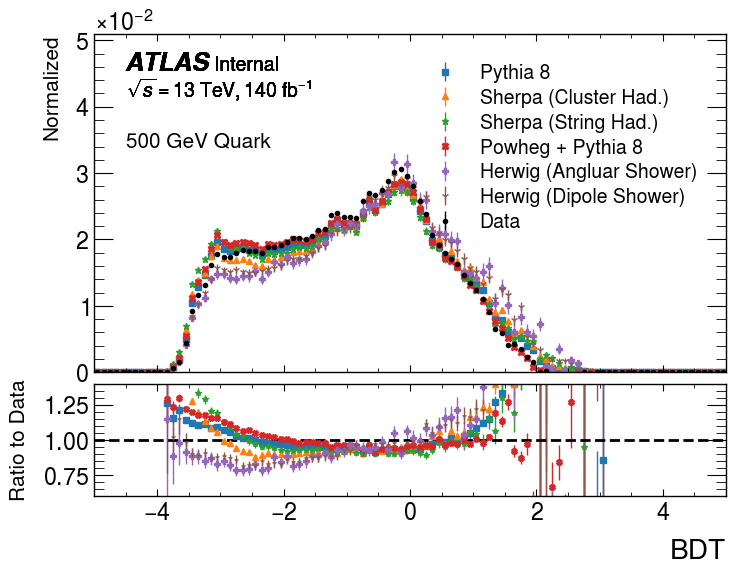

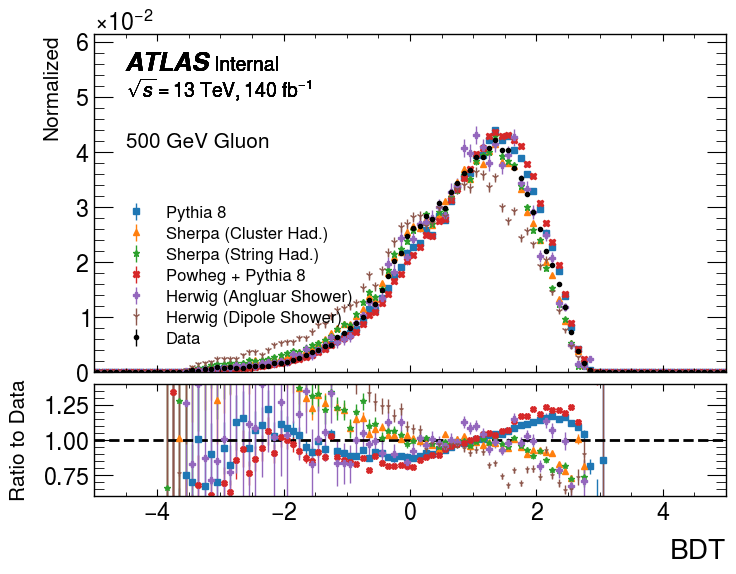

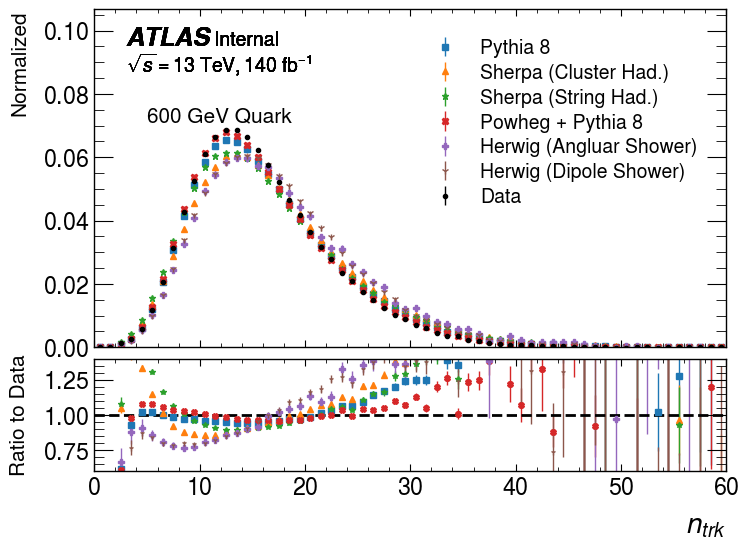

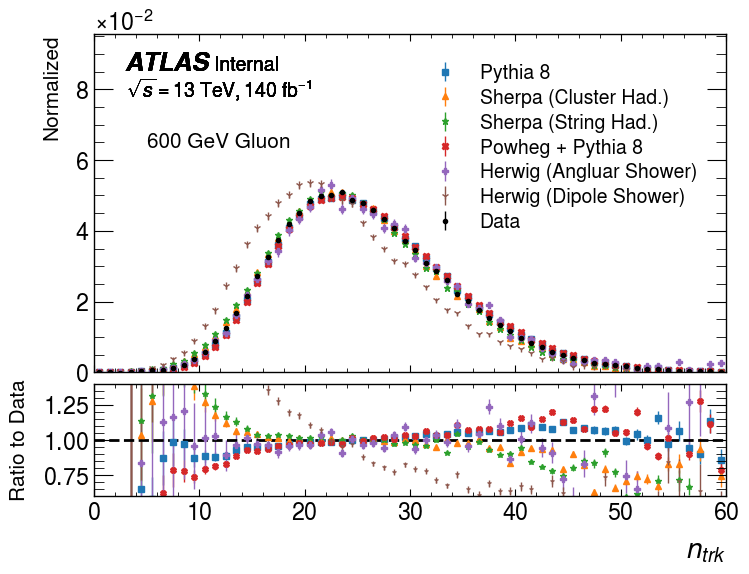

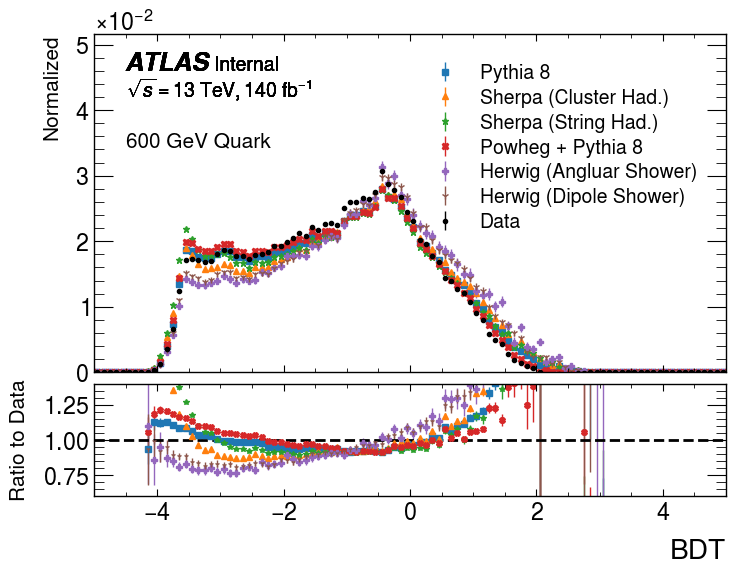

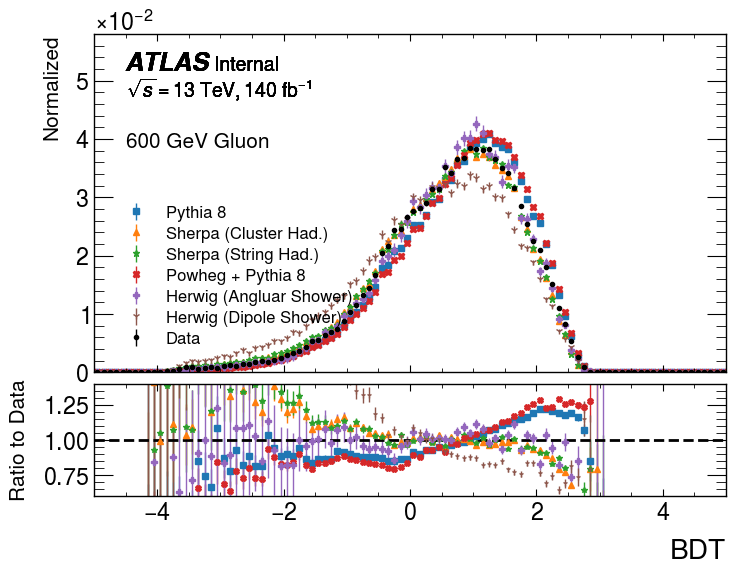

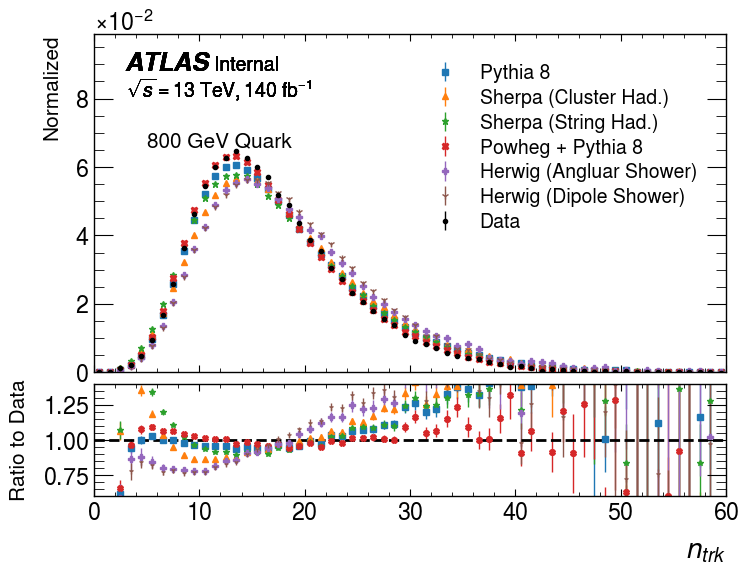

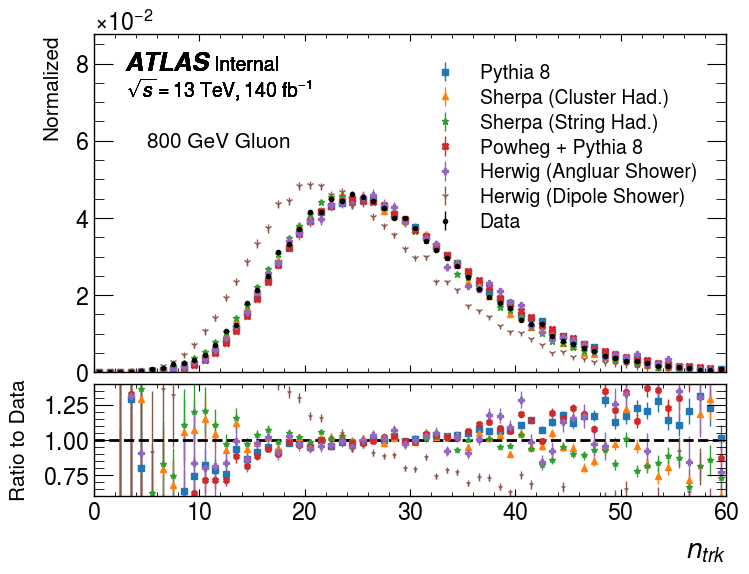

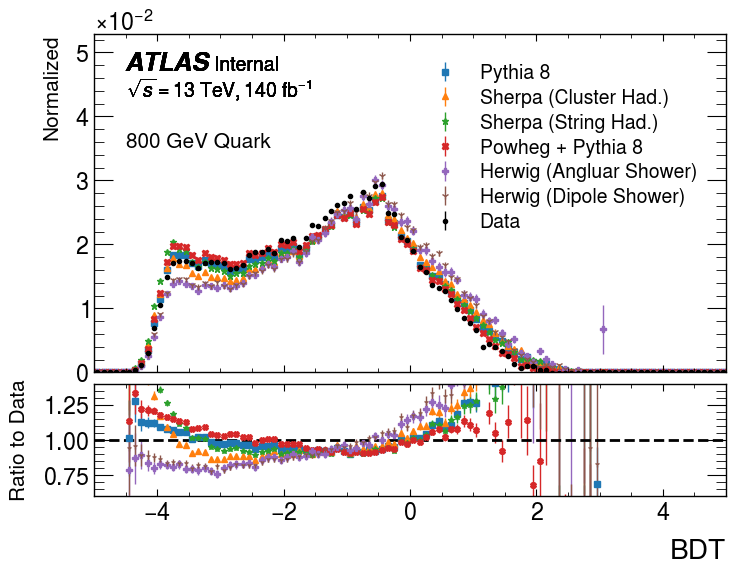

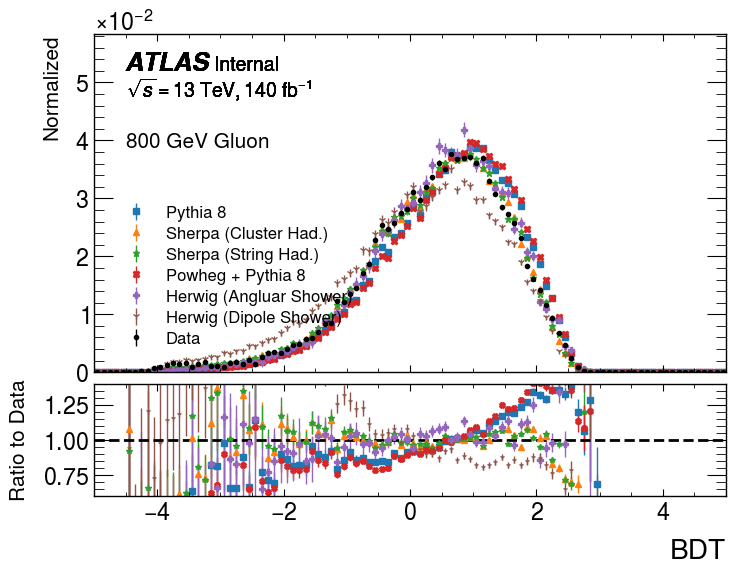

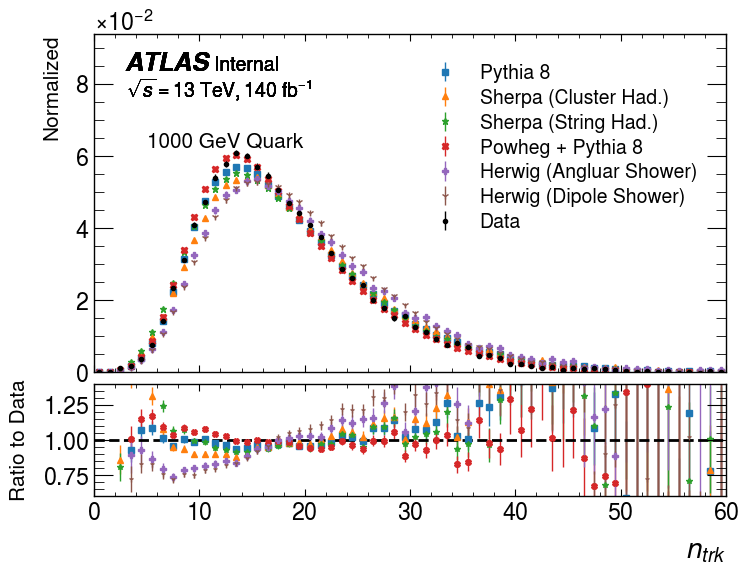

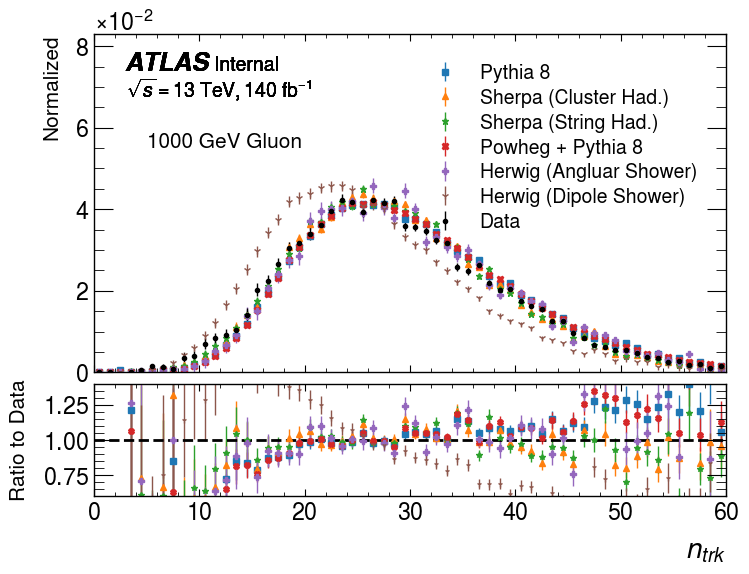

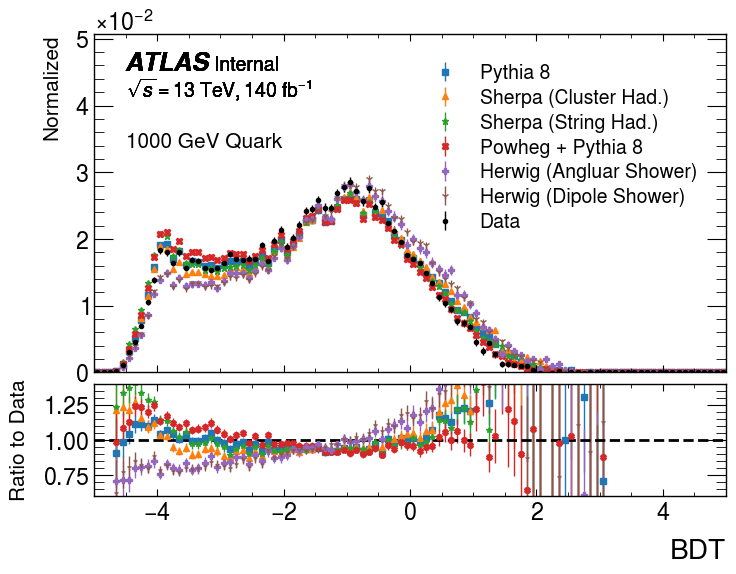

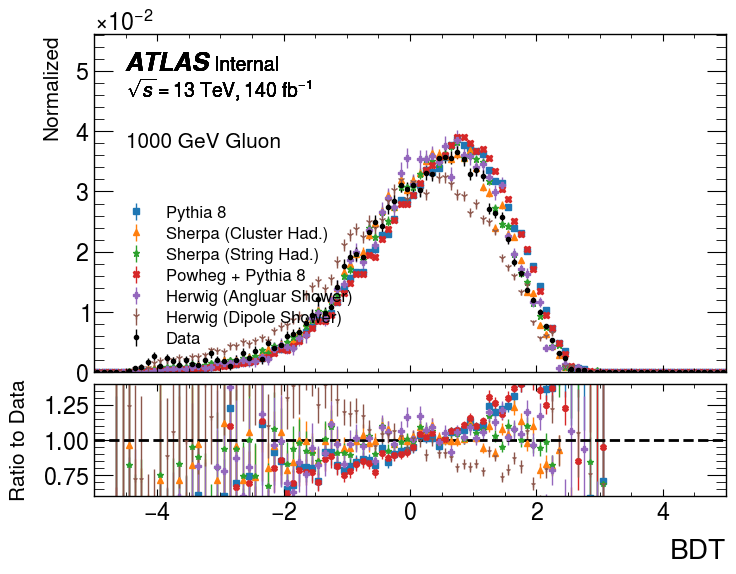

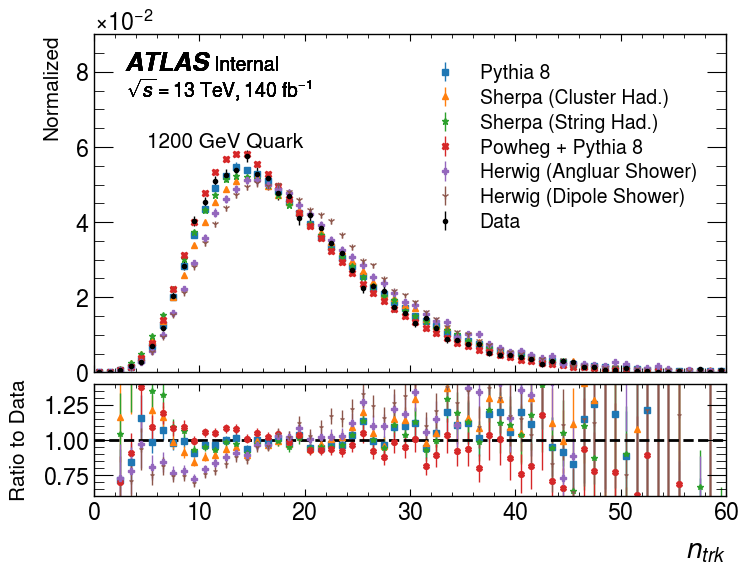

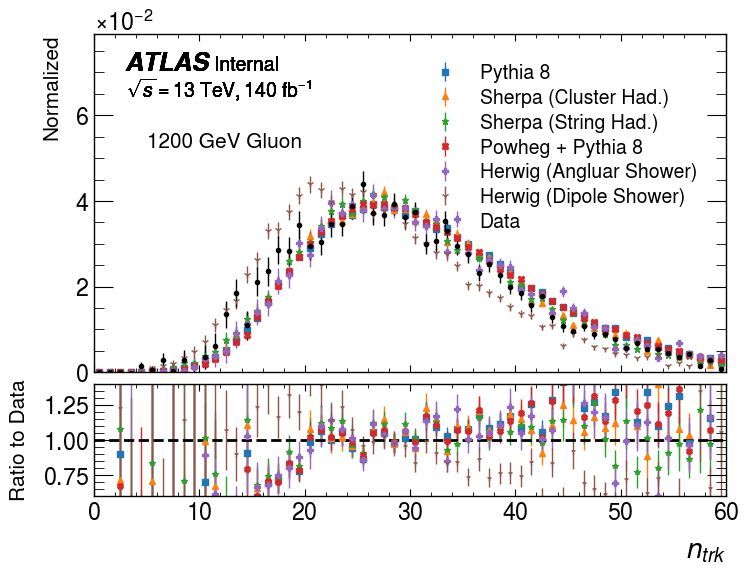

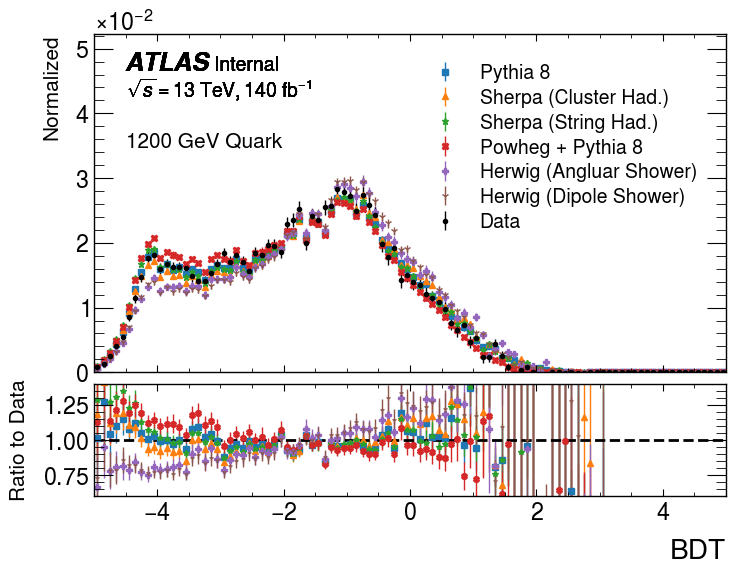

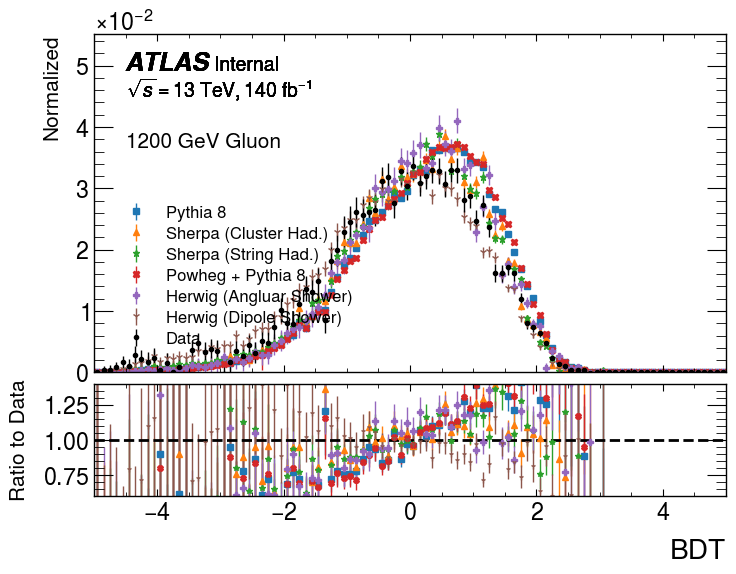

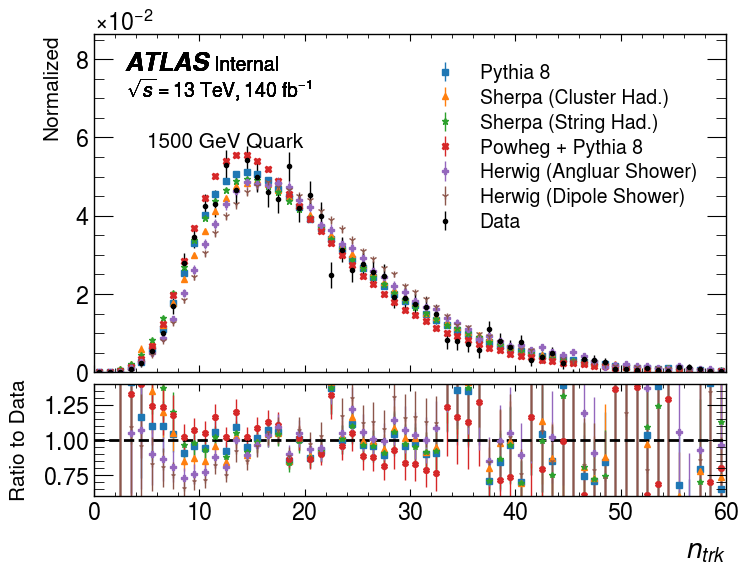

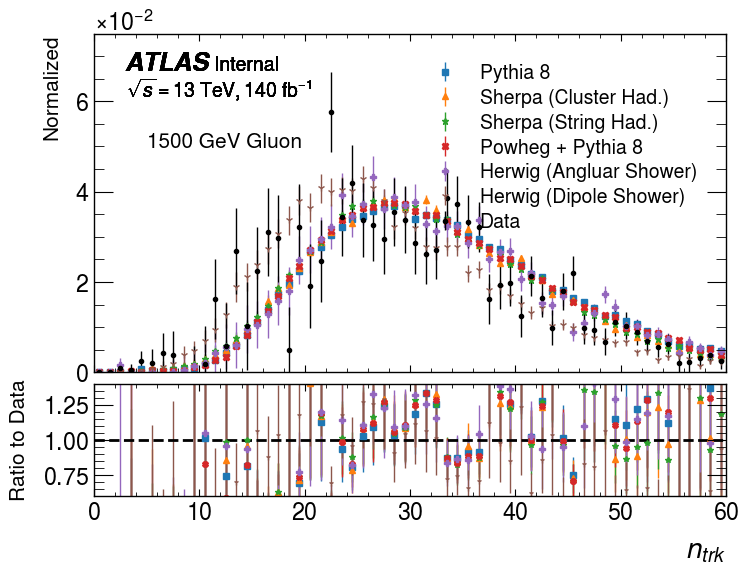

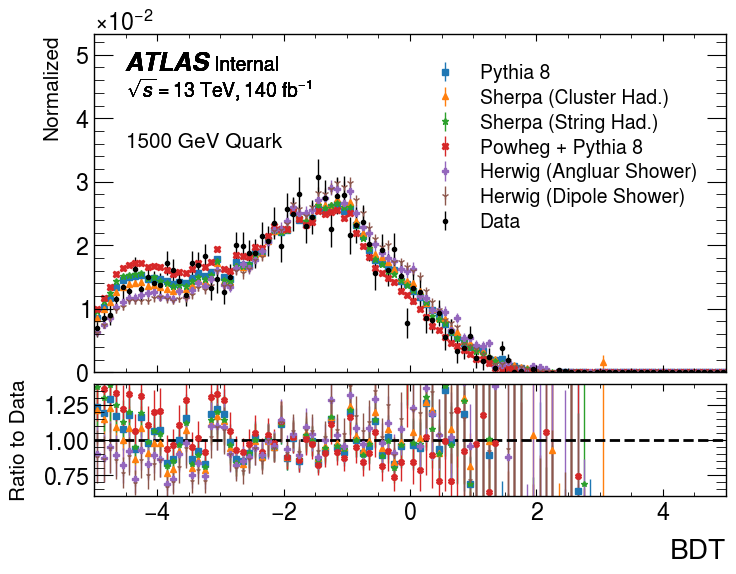

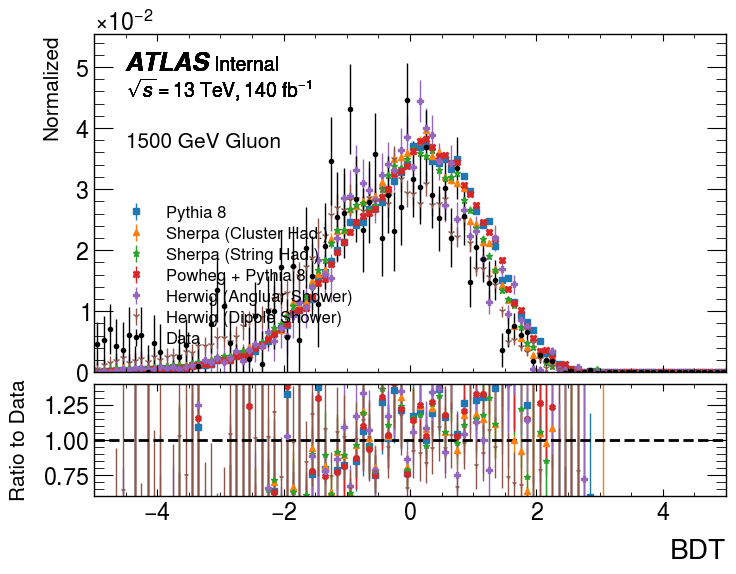

In [32]:
SFs = {}
Extraction_Results={}
syst_list=['nominal','hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']



for pt in label_ptrange:
    for var in reweighting_vars:
        bin_edges = HistBins[var]
        #bin_centers1 = 1/2 * (bin_edges[:-1] + bin_edges[1:])
        for parton in partons:
            #fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1], 'hspace': 0.1})
            fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

            for i, syst in enumerate(syst_list):
                syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'
                Extraction_Results[syst]= joblib.load(syst_path / f'{var}_Extraction_Results.pkl' )
            
                Extraction_var_pt =  Extraction_Results[syst][var][pt]
      
                syst_truth = Extraction_Results[syst][var][pt][f'p_{parton}']        
                syst_Q = Extraction_Results[syst][var][pt][f'extract_p_{parton}_MC']
                syst_data=Extraction_Results[syst][var][pt][f'extract_p_{parton}_Data']
                nom_data=Extraction_Results['nominal'][var][pt][f'extract_p_{parton}_Data']

                y_max = np.max(unumpy.nominal_values(syst_truth))


                #hep.histplot(unumpy.nominal_values(syst_truth),bins=bin_edges,label=f'Truth {syst}',ax=ax0,histtype='step',linestyle='--')
                #hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=f'Extracted {syst}',ax=ax0,histtype='step',linestyle='-')
                hep.histplot(unumpy.nominal_values(syst_Q),bins=bin_edges,label=Map_gen[syst],ax=ax0,histtype='errorbar',marker=markers[i],yerr=unumpy.std_devs(syst_Q),markersize=5)#,color=ind_all[i])

            
                ax0.set_ylim(0, y_max * 1.8)
                ytext=y_max * 1.2
                ax0.set_ylabel("Normalized",fontsize=15)
                hep.atlas.label(label='Internal',data=True,ax=ax0,lumi=140)

                ratio_truthMC_over_extractedMC = safe_array_divide_unumpy(syst_Q,nom_data)

                #ratio_truthMC_over_extractedMC2 = safe_array_divide_unumpy(syst_Q,syst_truth)
                hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC),bins=bin_edges,ax=ax1,histtype='errorbar',marker=markers[i],yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC),markersize=4)
                #hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC),bins=bin_edges,ax=ax1,histtype='errorbar',marker=".",color='black',yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC),xerr=True,markersize=4)
            hep.histplot(unumpy.nominal_values(nom_data),bins=bin_edges,label='Data',ax=ax0,histtype='errorbar',marker=".",color='black',yerr=unumpy.std_devs(nom_data),markersize=6)

            ax1.set_ylim(0.6,1.4)
                #ax2.set_ylim(0.6,1.4)
            #ax1.set_ylabel("MC closure",loc='center',fontsize=15)
            ax1.set_ylabel("Ratio to Data",loc='center',fontsize=15)
                #ax1.set_ylabel(r"$\frac{Extracted~MC}{Truth~MC}$",loc='center')
                #ax2.set_ylabel(r"$\frac{Data}{MC}$",loc='center')
            if var == 'GBDT_newScore' and parton == 'Gluon':
                ax0.legend(loc='lower left',fontsize=12)
            else:
                ax0.legend(loc='upper right')

            ax0.text(bin_edges[5],ytext,f'{pt} GeV {parton}',fontsize=15)
            ax1.set_xlim(bin_edges[0], bin_edges[-1])
            ax1.set_xlabel(f"{Map_var_title[var]}")
            ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')
                #ax2.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')

            fig.savefig(f'./mcclosure_gen/mcclosure_{var}_{parton}_{pt}_data.pdf')
                #fig.savefig(f'./mcclosure_sf/mcclosure_{var}_{parton}_{pt}_SF.pdf')

